<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/Copy_of_DS29_GP_Unit2_Sprint3_Module4_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

1. Announcements
2. Sample code for data imbalance
3. Work on a regression model 
4. Learn about PDP and SHAP plots
5. Talk about project module and SC

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

# I. Wrangle Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [28]:
def wrangle(filepath):
  history = pd.read_csv(filepath, parse_dates= ['issue_d'], index_col= 'issue_d').sort_index()

  history = history[history['term'] == ' 36 months']
  history = history.rename(columns = 
                           {'annual_inc': 'Annual Income',
                            'fico_range_high': 'Credit Score',
                            'title' : 'Loan Purpose',
                            'funded_amnt' : 'Loan Amount'})
  
  history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
  history['Monthly Debts'] = history['Annual Income']/12 * history['dti']/100

  columns = ['Annual Income',
             'Credit Score',
             'Loan Amount',
             'Loan Purpose',
             'Monthly Debts',
             'Interest Rate']
  history = history[columns]

  history.dropna(inplace = True)
  history['purpose_debt'] = history['Loan Purpose']

  history['purpose_debt'] = history['Loan Purpose'].str.lower().str.contains('debt').astype(int)
  history['purpose_credit'] = history['Loan Purpose'].str.lower().str.contains('credit').astype(int)
  history.drop(columns = 'Loan Purpose', inplace = True)

  history = history[history['Annual Income'] < 1_000_000]

  return history

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')
df.head()

,Annual Income,Credit Score,Loan Amount,Monthly Debts,Interest Rate,purpose_debt,purpose_credit
issue_d,,,,,,,
2007-07-01,20000.0,684.0,3500.0,25.000000,10.28,0,0
2007-07-01,95000.0,774.0,5000.0,303.208333,7.43,0,0
2007-07-01,150000.0,779.0,5000.0,0.000000,7.43,0,0
2007-07-01,200000.0,679.0,3000.0,0.000000,10.28,0,0
2007-08-01,61800.0,749.0,4000.0,178.190000,7.75,0,0


In [31]:
target = 'Interest Rate'
y = df[target]
X = df.drop(columns = target)

# II. Split Data

In [5]:
len(X)*0.6

81302.40000000001

In [32]:
cutoff1 = round(len(X)*0.6)
cutoff2 = round(len(X)*0.8)
X_train, y_train = X.iloc[:cutoff1], y.iloc[:cutoff1]
X_val, y_val = X.iloc[cutoff1:cutoff2], y.iloc[cutoff1:cutoff2]
X_test, y_test = X.iloc[cutoff2:], y.iloc[cutoff2:]

In [15]:
print(f'Length of training data: {len(X_train)}, {len(y_train)}.')
print(f'Length of validation data: {len(X_val)}, {len(y_val)}.')
print(f'Length of testing data: {len(X_test)}, {len(y_test)}.')
assert len(X_train) + len(X_val) + len(X_test)== len(X)

Length of training data: 60977, 60977.
Length of validation data: 20325, 20325.
Length of testing data: 20326, 20326.


# III. Establish Baseline

In [16]:
from sklearn.metrics import mean_absolute_error
y_pred = [y_train.mean()]*len(y_train)
print('Baseline MAE: ', mean_absolute_error(y_train, y_pred))

Baseline MAE:  2.8715656644171257


# IV. Build Model

In [9]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [17]:
model_boost = XGBRegressor(random_state = 42)
model_boost.fit(X_train, y_train)

model_forest = RandomForestRegressor(random_state = 42)
model_forest.fit(X_train, y_train)

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

[01:10:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

In [18]:
for model in [model_boost, model_forest, model_linear]:
  print(type(model))
  print('Training MAE: ', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R-Squared:', model.score(X_val, y_val))
  print()

<class 'xgboost.sklearn.XGBRegressor'>
Training MAE:  2.1664958629598456
Validation MAE 2.527210703276649
Validation R-Squared: 0.2712804643033042

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE:  0.8439938944270162
Validation MAE 2.590890549510923
Validation R-Squared: 0.225276860371046

<class 'sklearn.linear_model._base.LinearRegression'>
Training MAE:  2.3102099496420774
Validation MAE 2.6567101152893944
Validation R-Squared: 0.1980843677258185



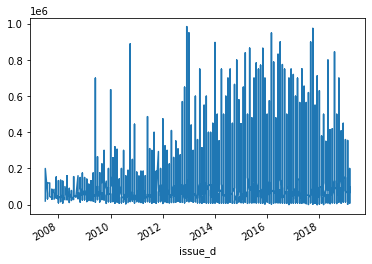

In [29]:
df['Annual Income'].plot()

# VI. Communicate Results

## Partial Dependence Plots

One Feature

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f10abfaf890>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f10ad936f10>})

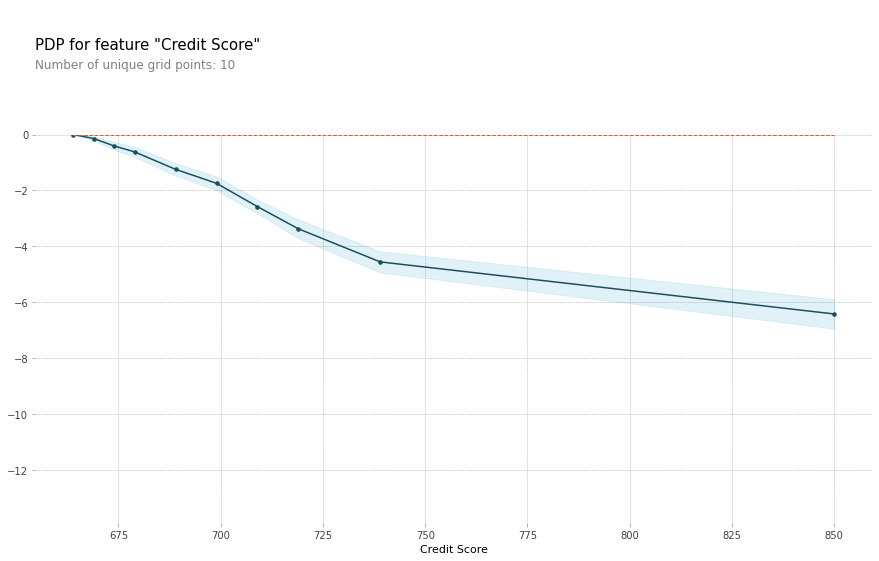

In [34]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Credit Score'

isolate = pdp_isolate(
    model = model_boost,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)
pdp_plot(isolate, feature_name = feature)

Two features

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f10ac68f4d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f10abde1390>})

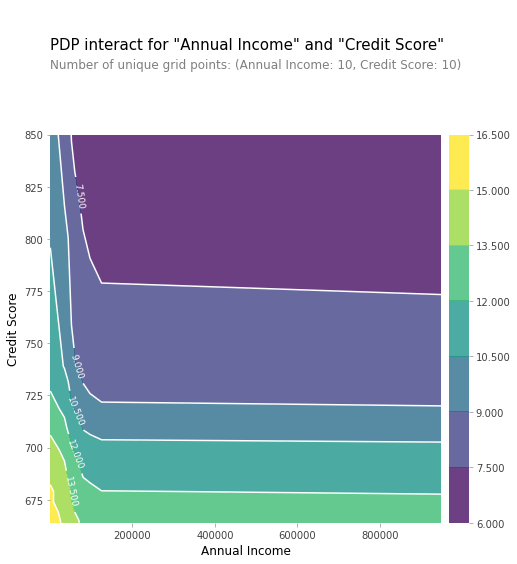

In [40]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Annual Income', 'Credit Score']

interact = pdp_interact(
    model = model_boost,
    dataset = X_val,
    model_features = X_val.columns,
    features = features
)

pdp_interact_plot(interact, plot_type = 'contour', feature_names = features)

## Shapley Plots

- Show you the influence of features in *individual* predictions.

In [48]:
row = X_train.iloc[[52]]
row

,Annual Income,Credit Score,Loan Amount,Monthly Debts,purpose_debt,purpose_credit
issue_d,,,,,,
2008-02-01,48000.0,704.0,7200.0,505.2,0,1


In [42]:
model_boost.predict(row)

array([15.109936], dtype=float32)

In [50]:
import shap
explainer = shap.TreeExplainer(model_boost)
shap_values = explainer.shap_values(row)

shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row)

TypeError: ignored

In [ ]:
import shap
explainer = shap.LinearExplainer(model_linear)
shap_values = explainer.shap_values(row)

shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row)

In [46]:
dir(explainer)

['_Tree__dynamic_expected_value',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_main_effects',
 '_get_shap_interactions_output',
 '_get_shap_output',
 '_instantiated_load',
 '_validate_inputs',
 'assert_additivity',
 'data',
 'data_missing',
 'expected_value',
 'explain_row',
 'feature_names',
 'feature_perturbation',
 'link',
 'load',
 'masker',
 'model',
 'model_output',
 'output_names',
 'save',
 'shap_interaction_values',
 'shap_values',
 'supports_model_with_masker']